# Step Forward Cross Validation for Bioactivity Prediction

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../benchmark/data/results/target_CHEMBL260-1.IC50.csv")

In [3]:
df

,Unnamed: 0.1,Unnamed: 0,assay_chembl_id,compound_chembl_id,canonical_smiles,pchembl_value,standardized_smiles,LogD,LogP,MCE18,...,UnsortedStepForward_Fold_6_AtomPairsFP_mlp_regressor_factory,UnsortedStepForward_Fold_7_AtomPairsFP_rf_regressor_factory,UnsortedStepForward_Fold_7_AtomPairsFP_xgb_regressor_factory,UnsortedStepForward_Fold_7_AtomPairsFP_mlp_regressor_factory,UnsortedStepForward_Fold_8_AtomPairsFP_rf_regressor_factory,UnsortedStepForward_Fold_8_AtomPairsFP_xgb_regressor_factory,UnsortedStepForward_Fold_8_AtomPairsFP_mlp_regressor_factory,UnsortedStepForward_Fold_9_AtomPairsFP_rf_regressor_factory,UnsortedStepForward_Fold_9_AtomPairsFP_xgb_regressor_factory,UnsortedStepForward_Fold_9_AtomPairsFP_mlp_regressor_factory
0,0,0,CHEMBL874544,CHEMBL364576,COc1cc2ncnc(Nc3cc(NC(=O)c4cccc(N(C)C)c4)ccc3C)...,7.52,COc1cc2ncnc(Nc3cc(NC(=O)c4cccc(N(C)C)c4)ccc3C)...,3.895002,5.01732,96.000000,...,7.499772,7.2908,7.233397,7.510861,7.384000,7.252442,7.130674,7.2556,7.280485,7.437154
1,1,1,CHEMBL874544,CHEMBL363462,COc1cc2ncnc(Nc3cc(NC(=O)c4ccnc(N5CCOCC5)c4)ccc...,7.30,COc1cc2ncnc(Nc3cc(NC(=O)c4ccnc(N5CCOCC5)c4)ccc...,4.247823,5.67192,153.777778,...,7.345269,7.1312,7.305170,7.174205,7.196400,7.325721,7.125622,7.2276,7.352294,7.402245
2,2,2,CHEMBL874544,CHEMBL187007,COc1cc2ncnc(Nc3cc(NC(=O)c4cccc(N(C)C)c4)ccc3Cl...,7.40,COc1cc2ncnc(Nc3cc(NC(=O)c4cccc(N(C)C)c4)ccc3Cl...,4.136765,5.36230,96.000000,...,7.118215,6.7720,6.947188,6.855859,7.369200,7.273814,7.174780,7.0868,7.234376,7.347954
3,3,3,CHEMBL874544,CHEMBL185327,COc1cc2ncnc(Nc3cc(NC(=O)c4ccccc4)ccc3Cl)c2cc1OC,7.10,COc1cc2ncnc(Nc3cc(NC(=O)c4ccccc4)ccc3Cl)c2cc1OC,4.353839,5.29630,88.000000,...,6.937078,6.8344,6.895032,6.876305,7.043200,6.717153,6.581289,6.6952,6.894189,6.947467
4,4,4,CHEMBL874544,CHEMBL185315,Cc1ccc(NC(=O)c2ccnc(N3CCOCC3)c2)cc1Nc1ccnc(OC2...,7.40,Cc1ccc(NC(=O)c2ccnc(N3CCOCC3)c2)cc1Nc1ccnc(OC2...,2.038770,3.48552,138.987198,...,7.426252,6.9456,7.328664,7.343741,7.253600,7.294348,7.594102,7.2416,7.412970,7.485607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,1459,1459,CHEMBL5042748,CHEMBL5074845,O=C(O)CCNC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3ccc(F)c...,8.26,O=C(O)CCNC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3ccc(F)c...,0.758207,4.24250,98.507837,...,8.355580,8.3228,8.410530,8.714734,8.270800,8.455015,8.580400,8.2628,8.259640,8.700075
1460,1460,1460,CHEMBL5042748,CHEMBL5089786,Nc1ccccc1Nc1ccc2c(c1)CCc1ccc(C(=O)NCCc3cnc[nH]...,7.58,Nc1ccccc1Nc1ccc2c(c1)CCc1ccc(C(=O)NCCc3cnc[nH]...,2.596063,4.03760,132.664137,...,7.629970,7.6840,7.733707,7.686386,7.720400,7.721233,7.561486,7.8408,7.740797,7.644529
1461,1461,1461,CHEMBL5042748,CHEMBL5094704,COC(=O)CC[C@H](NC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3...,7.77,COC(=O)CC[C@H](NC(=O)c1ccc2c(c1)C(=O)c1ccc(Nc3...,2.731937,3.56660,127.119883,...,8.074177,7.8752,7.880938,7.823106,7.883200,7.993715,7.707234,7.8668,7.787151,7.936854
1462,1462,1462,CHEMBL5042748,CHEMBL5093265,COC(=O)[C@@H](N)CCNC(=O)c1ccc2c(c1)C(=O)c1ccc(...,8.64,COC(=O)[C@@H](N)CCNC(=O)c1ccc2c(c1)C(=O)c1ccc(...,2.100483,3.65820,127.272727,...,8.648041,8.3504,8.516775,8.681889,8.487467,8.561366,8.679151,8.2512,8.351074,8.728965


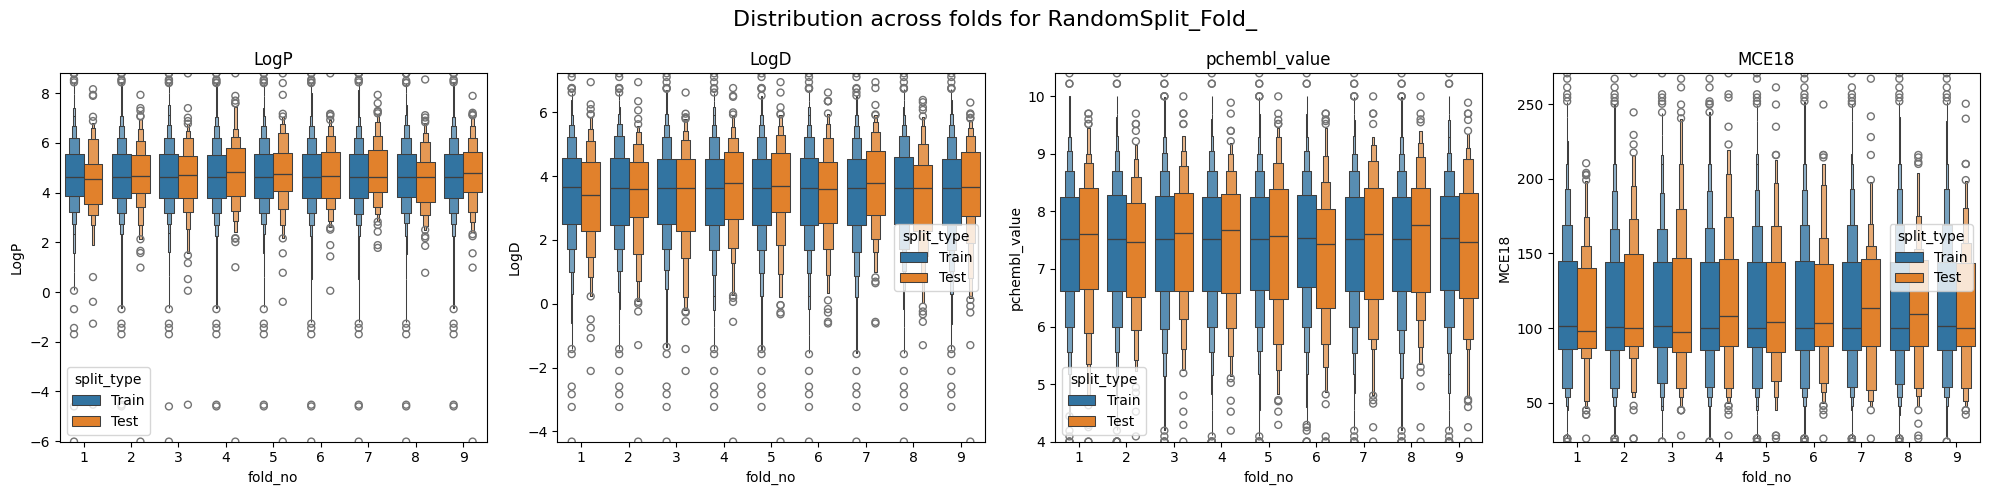

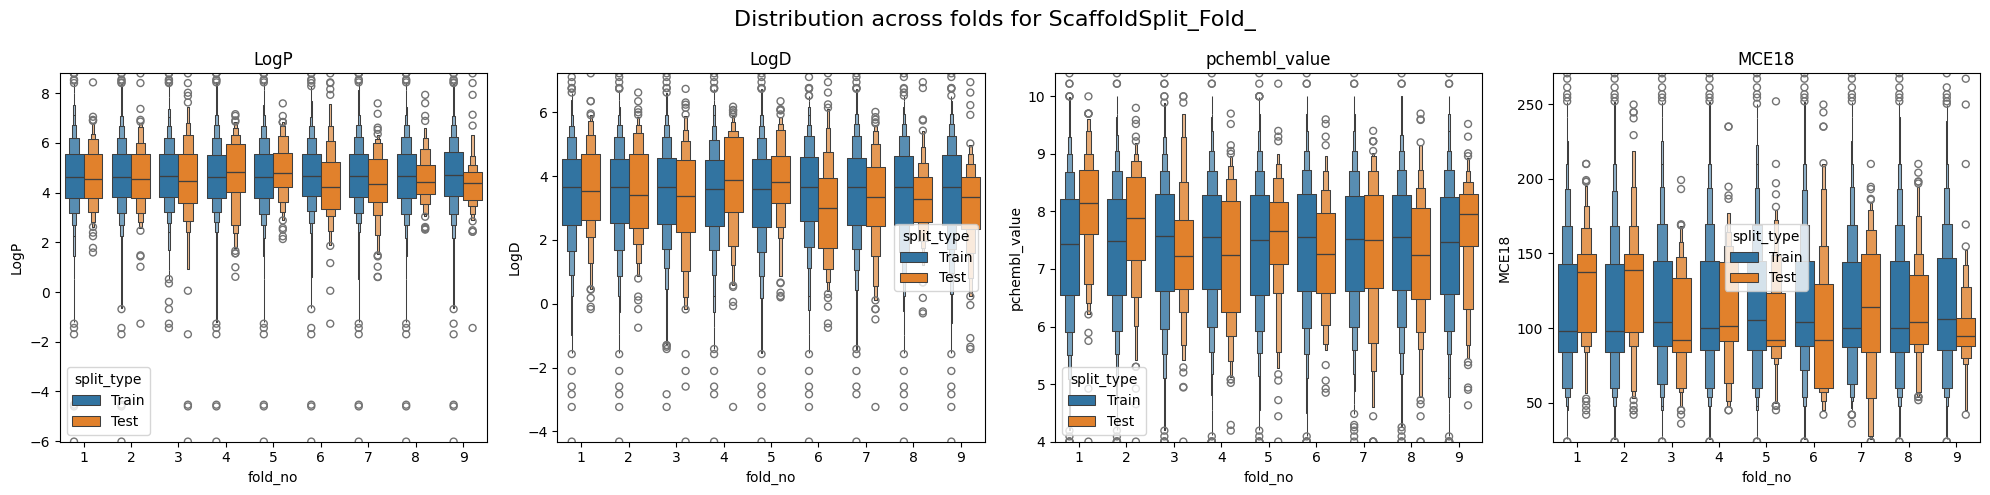

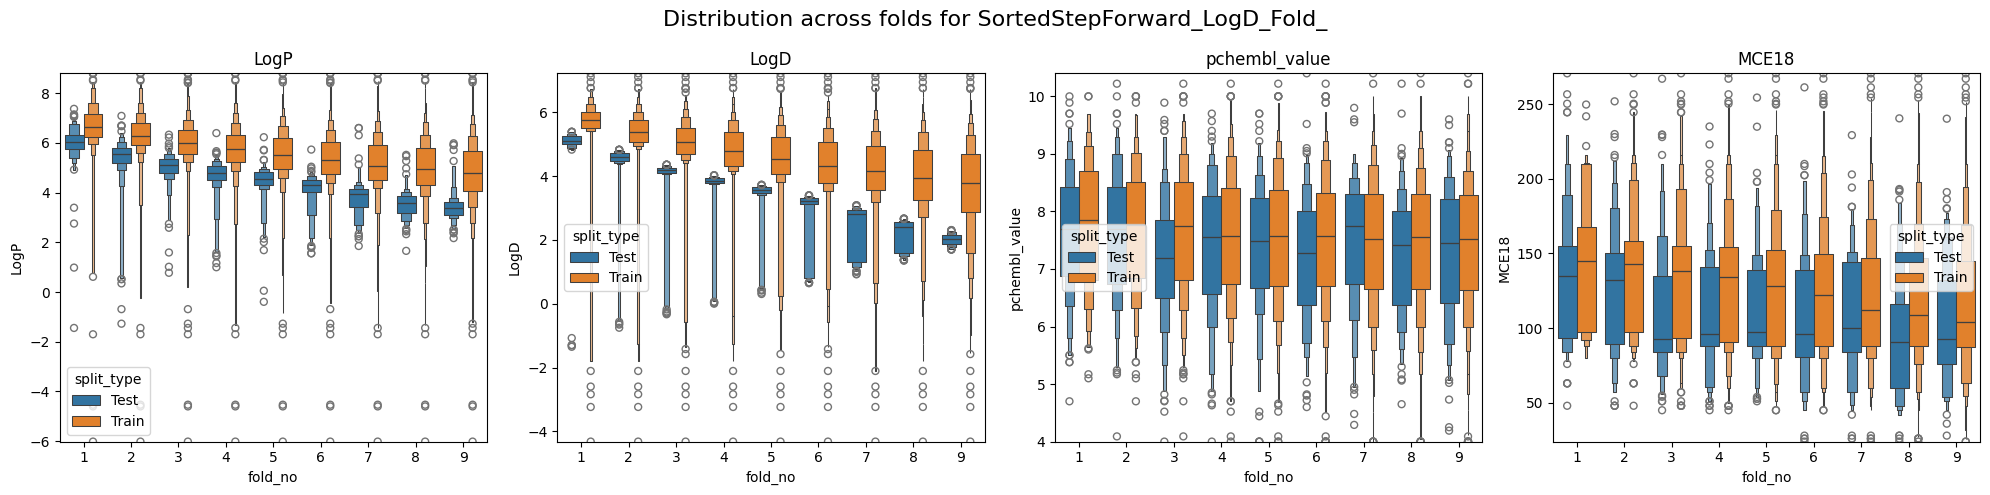

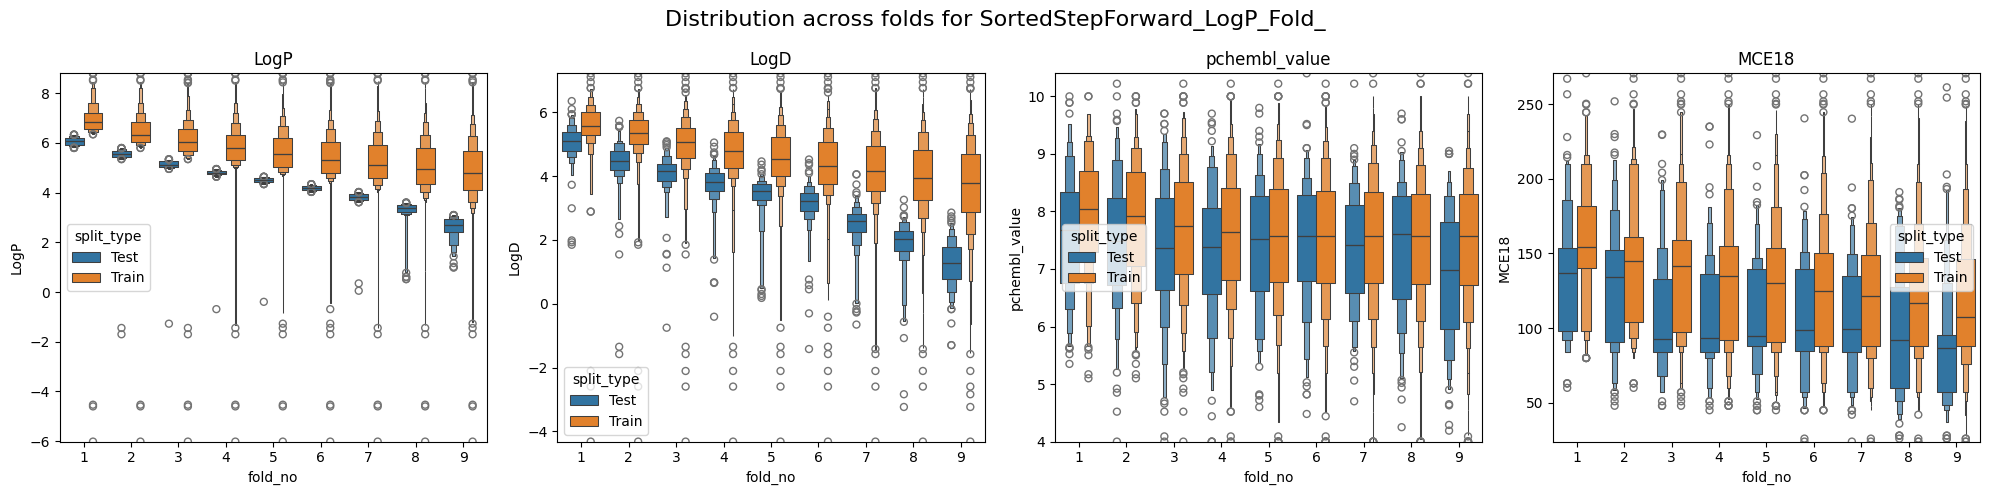

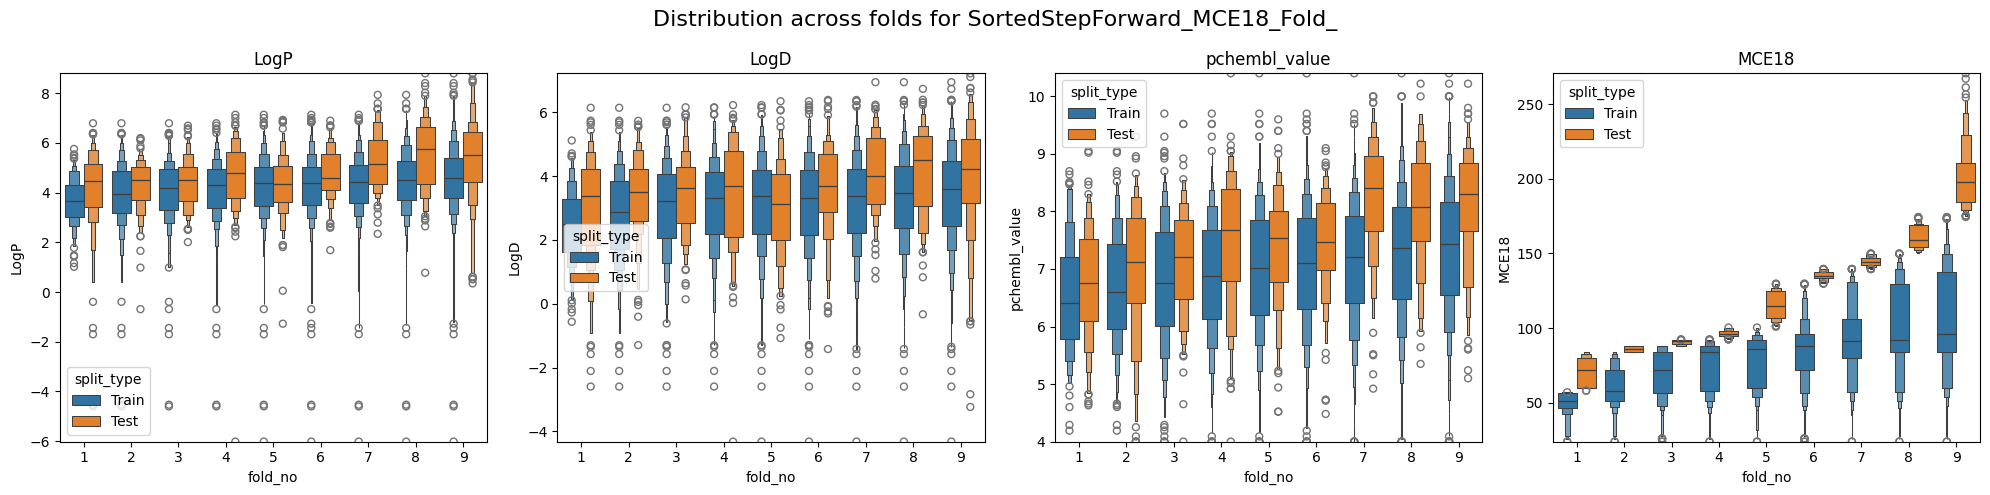

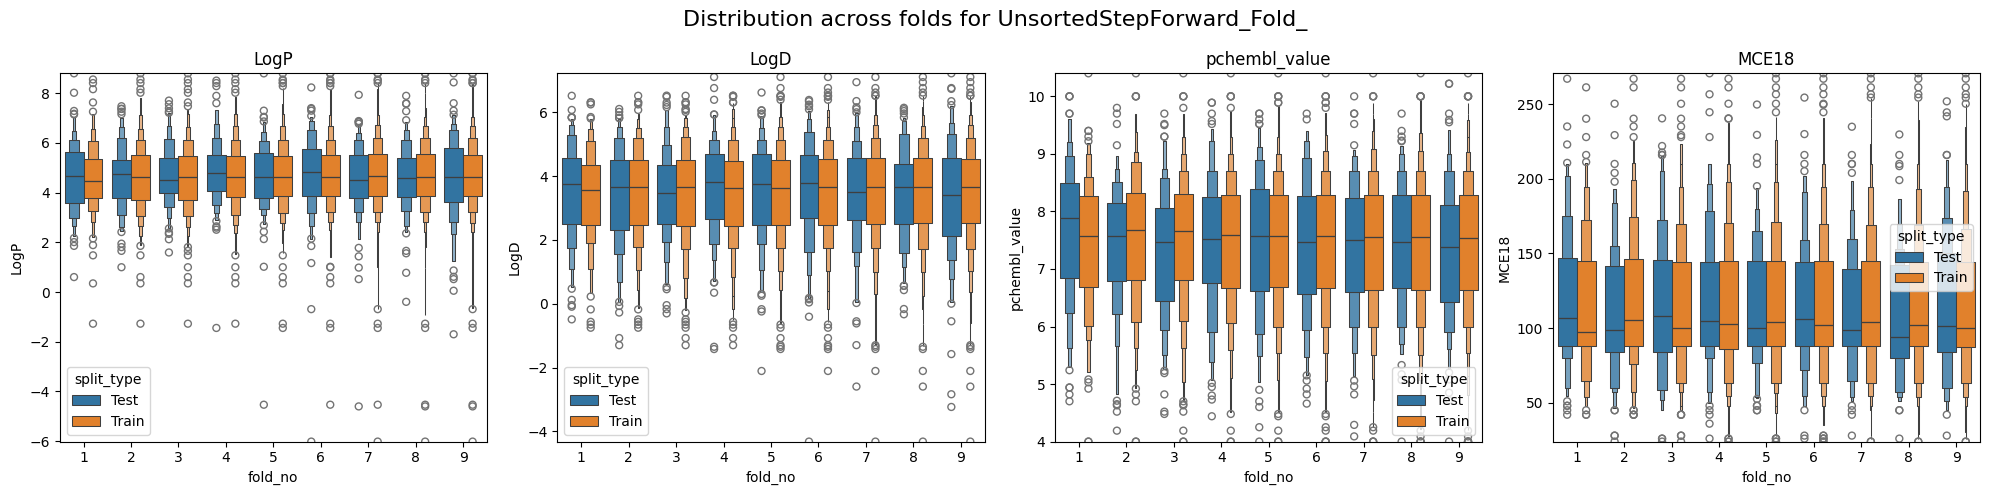

In [4]:
properties = ["LogP", "LogD", "pchembl_value", "MCE18"]
split_types = ['RandomSplit_Fold_', 'ScaffoldSplit_Fold_', 'SortedStepForward_LogD_Fold_',
               'SortedStepForward_LogP_Fold_', 'SortedStepForward_MCE18_Fold_', 'UnsortedStepForward_Fold_']
# Ensure fold columns contain numeric fold numbers
for split_type in split_types:
    fold_cols = [f"{split_type}{i}" for i in range(1, 10)]
    df_long = df.melt(id_vars=properties, value_vars=fold_cols,
                      var_name="fold_no", value_name="split_type")
    df_long["fold_no"] = df_long["fold_no"].str.extract(r'_Fold_(\d+)').astype(int)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Distribution across folds for {split_type}", fontsize=16)

    for i, prop in enumerate(properties):
        sns.boxenplot(x="fold_no", y=prop, data=df_long, ax=axes[i], hue="split_type")
        axes[i].set_title(prop)
        axes[i].tick_params(axis='x')
        axes[i].set_ylim(df[prop].min(), df[prop].max())  # Scale each subplot independently

    plt.tight_layout()
    plt.show()


In [5]:
def plot_dissimilar_compounds_using_Tc(df, threshold=0.55, split_types=split_types,
                                       fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"]):
    fig, axes = plt.subplots(1, len(fp_cols), figsize=(7 * len(fp_cols), 6), sharey=True)

    if len(fp_cols) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for ax, fp_col in zip(axes, fp_cols):
        for split_prefix in split_types:
            Tc_cols = [col for col in df.columns if col.startswith(split_prefix) and col.endswith(f"_{fp_col}_Tc")]
            batch_counts = [(df[Tc_col] < threshold).sum() for Tc_col in Tc_cols]

            ax.plot(range(1, len(batch_counts) + 1), batch_counts, marker='o', label=split_prefix)

        ax.set_xlabel("Testing Batch", fontsize=12)
        ax.set_title(f"{fp_col}", fontsize=14)
        ax.legend(title="Split Types", fontsize=10)
        ax.grid(True)

    axes[0].set_ylabel("Number of Molecules", fontsize=12)  # Leftmost plot gets the ylabel

    plt.tight_layout()
    plt.show()

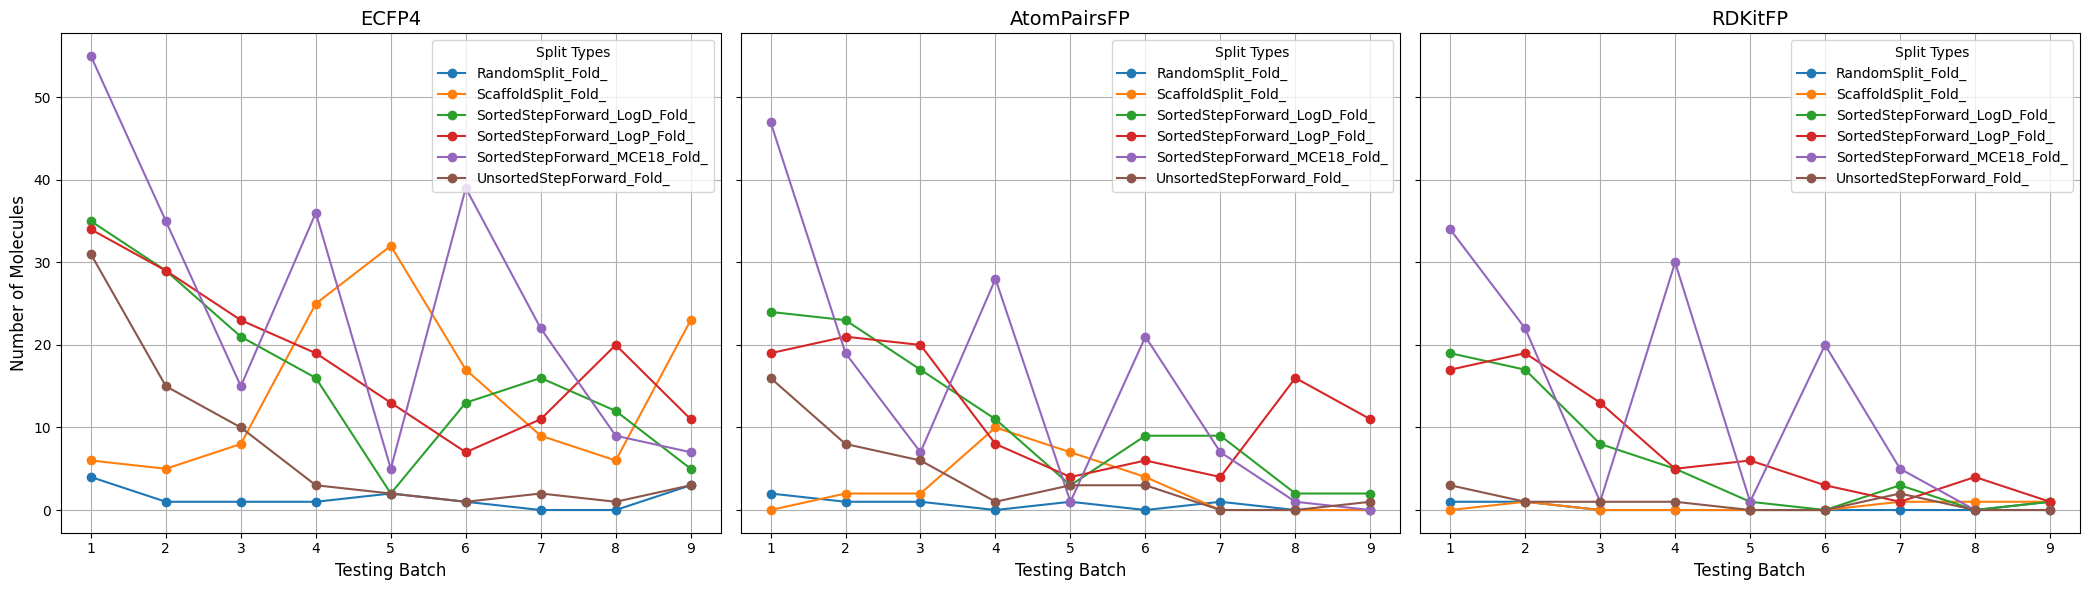

In [6]:
plot_dissimilar_compounds_using_Tc(df, threshold=0.55)

In [7]:
pred_cols = [col for col in df.columns if
             col.startswith(split_types[0]) and col.endswith(f"ECFP4_rf_regressor_factory")]

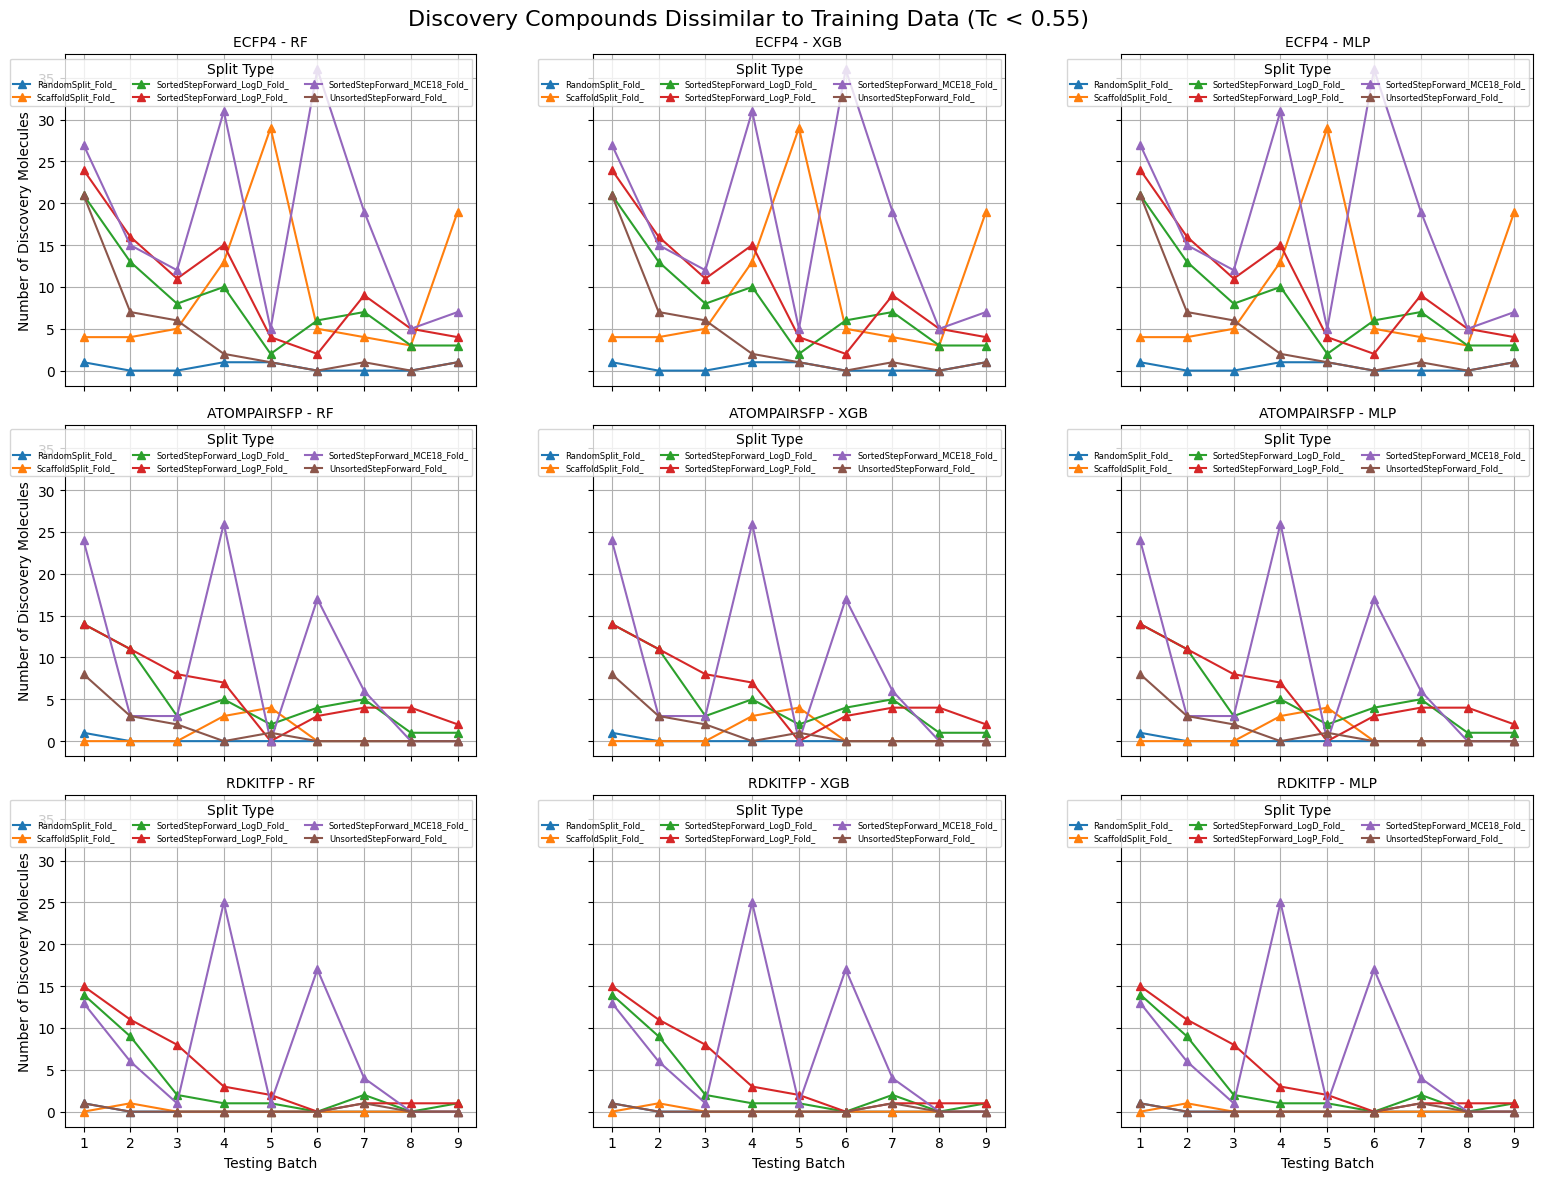

In [8]:
def plot_discovery_dissimilar_compounds_grid(
        df,
        condition="pchembl_value < 5.2",
        similarity_threshold=0.55,
        split_types=split_types,
        fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"],
        models=["rf", "xgb", "mlp"]
):
    fig, axes = plt.subplots(len(fp_cols), len(models), figsize=(16, 12), sharex=True, sharey=True)

    for i, fp_col in enumerate(fp_cols):
        for j, model in enumerate(models):
            ax = axes[i, j] if len(fp_cols) > 1 else axes[j]  # Handle axes for single row
            for split_prefix in split_types:
                pred_cols = [col for col in df.columns if
                             col.startswith(f"{split_prefix}") and col.endswith(f"_{fp_col}_{model}_regressor_factory")]
                batch_counts = []

                for pred_col in pred_cols:
                    match = re.search(r"Fold_(\d+)", pred_col)
                    if not match:
                        print(pred_col)
                        print("WTF")
                        continue
                    fold_number = match.group(1)

                    # Construct the corresponding similarity column name
                    similarity_col = f"{split_prefix}{fold_number}_{fp_col}_Tc"
                    if similarity_col not in df.columns:
                        print(f"[Missing] !! {similarity_col} !! [Missing]")
                        raise Exception()

                    # Filter test set compounds
                    split_col = pred_col.replace(f"_{fp_col}_{model}_regressor_factory", "")
                    test_indices = df.index[df[split_col] == "Test"]

                    # Extract true and predicted values
                    true_values = df.loc[test_indices, "pchembl_value"]
                    predicted_values = df.loc[test_indices, pred_col]

                    # Evaluate the condition dynamically
                    discovery_condition = df.loc[test_indices].eval(condition)

                    # Check Tanimoto similarity (Tc < threshold)
                    dissimilar_condition = df.loc[test_indices, similarity_col] < similarity_threshold
                    discovery_dissimilar = discovery_condition & dissimilar_condition

                    # Count discovery compounds dissimilar to training data
                    within_error = discovery_dissimilar.sum()
                    batch_counts.append(within_error)

                # Add the results for this split type to the plot
                ax.plot(
                    range(1, len(batch_counts) + 1),
                    batch_counts,
                    marker='^',
                    label=f"{split_prefix}"
                )

            # Customize each subplot
            ax.set_title(f"{fp_col.upper()} - {model.upper()}", fontsize=10)
            if j == 0:
                ax.set_ylabel("Number of Discovery Molecules", fontsize=10)
            if i == len(fp_cols) - 1:
                ax.set_xlabel("Testing Batch", fontsize=10)
            ax.legend(title="Split Type", fontsize=6, ncols=3, loc="upper right")
            ax.grid(True)

    fig.suptitle(f"Discovery Compounds Dissimilar to Training Data (Tc < {similarity_threshold})", fontsize=16)
    plt.tight_layout()
    plt.show()


plot_discovery_dissimilar_compounds_grid(df, condition="pchembl_value > 7", similarity_threshold=0.55)

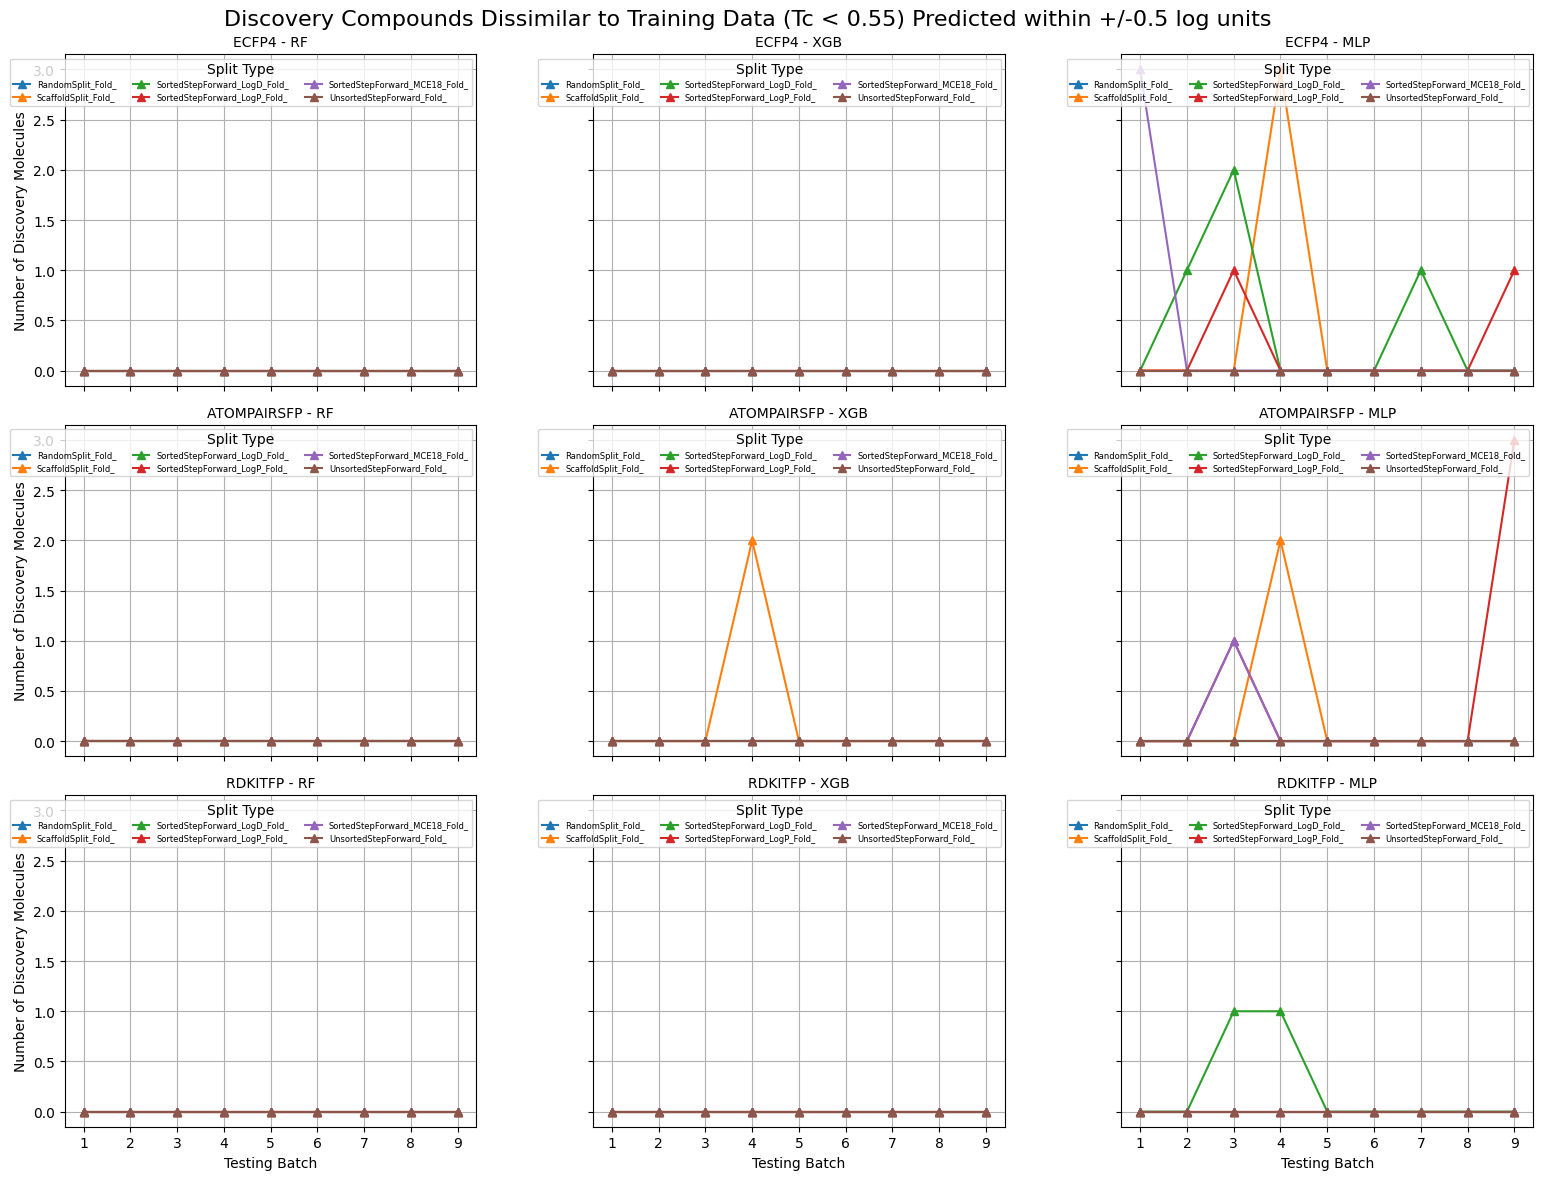

In [9]:
def plot_discovery_dissimilar_within_error_grid(
        df,
        error_range=0.5,
        condition="pchembl_value < 5.2",
        similarity_threshold=0.55,
        split_types=split_types,
        fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"],
        models=["rf", "xgb", "mlp"]
):
    fig, axes = plt.subplots(len(fp_cols), len(models), figsize=(16, 12), sharex=True, sharey=True)

    for i, fp_col in enumerate(fp_cols):
        for j, model in enumerate(models):
            ax = axes[i, j] if len(fp_cols) > 1 else axes[j]  # Handle axes for single row
            for split_prefix in split_types:
                # Identify prediction columns for the split, fingerprint, and model
                pred_cols = [col for col in df.columns if col.startswith(f"{split_prefix}") and col.endswith(
                    f"_{fp_col}_{model}_regressor_factory")]
                batch_counts = []

                for pred_col in pred_cols:
                    # Extract fold number dynamically
                    match = re.search(r"Fold_(\d+)", pred_col)
                    if not match:
                        print("WTF")
                        continue
                    fold_number = match.group(1)

                    # Construct the corresponding similarity column name
                    similarity_col = f"{split_prefix}{fold_number}_{fp_col}_Tc"

                    if similarity_col not in df.columns:
                        print(f"[Missing] !! {similarity_col} !! [Missing]")
                        continue  # Skip if the similarity column doesn't exist

                    # Filter test set compounds
                    split_col = pred_col.replace(f"_{fp_col}_{model}_regressor_factory", "")
                    test_indices = df.index[df[split_col] == "Test"]

                    # Extract true and predicted values
                    true_values = df.loc[test_indices, "pchembl_value"]
                    predicted_values = df.loc[test_indices, pred_col]

                    discovery_condition = df.loc[test_indices].eval(condition)
                    dissimilar_condition = df.loc[test_indices, similarity_col] < similarity_threshold
                    within_error_condition = abs(true_values - predicted_values) <= error_range
                    discovery_dissimilar = discovery_condition & dissimilar_condition & within_error_condition

                    # Count discovery compounds dissimilar to training data
                    within_error = discovery_dissimilar.sum()
                    batch_counts.append(within_error)

                # Add the results for this split type to the plot
                ax.plot(
                    range(1, len(batch_counts) + 1),
                    batch_counts,
                    marker='^',
                    label=f"{split_prefix}"
                )

            # Customize each subplot
            ax.set_title(f"{fp_col.upper()} - {model.upper()}", fontsize=10)
            if j == 0:
                ax.set_ylabel("Number of Discovery Molecules", fontsize=10)
            if i == len(fp_cols) - 1:
                ax.set_xlabel("Testing Batch", fontsize=10)
            ax.legend(title="Split Type", fontsize=6, ncols=3, loc="upper right")
            ax.grid(True)

    fig.suptitle(
        f"Discovery Compounds Dissimilar to Training Data (Tc < {similarity_threshold}) Predicted within +/-{error_range} log units",
        fontsize=16)
    plt.tight_layout()
    plt.show()


plot_discovery_dissimilar_within_error_grid(df, error_range=0.5, condition="pchembl_value < 5.2",
                                            similarity_threshold=0.55)

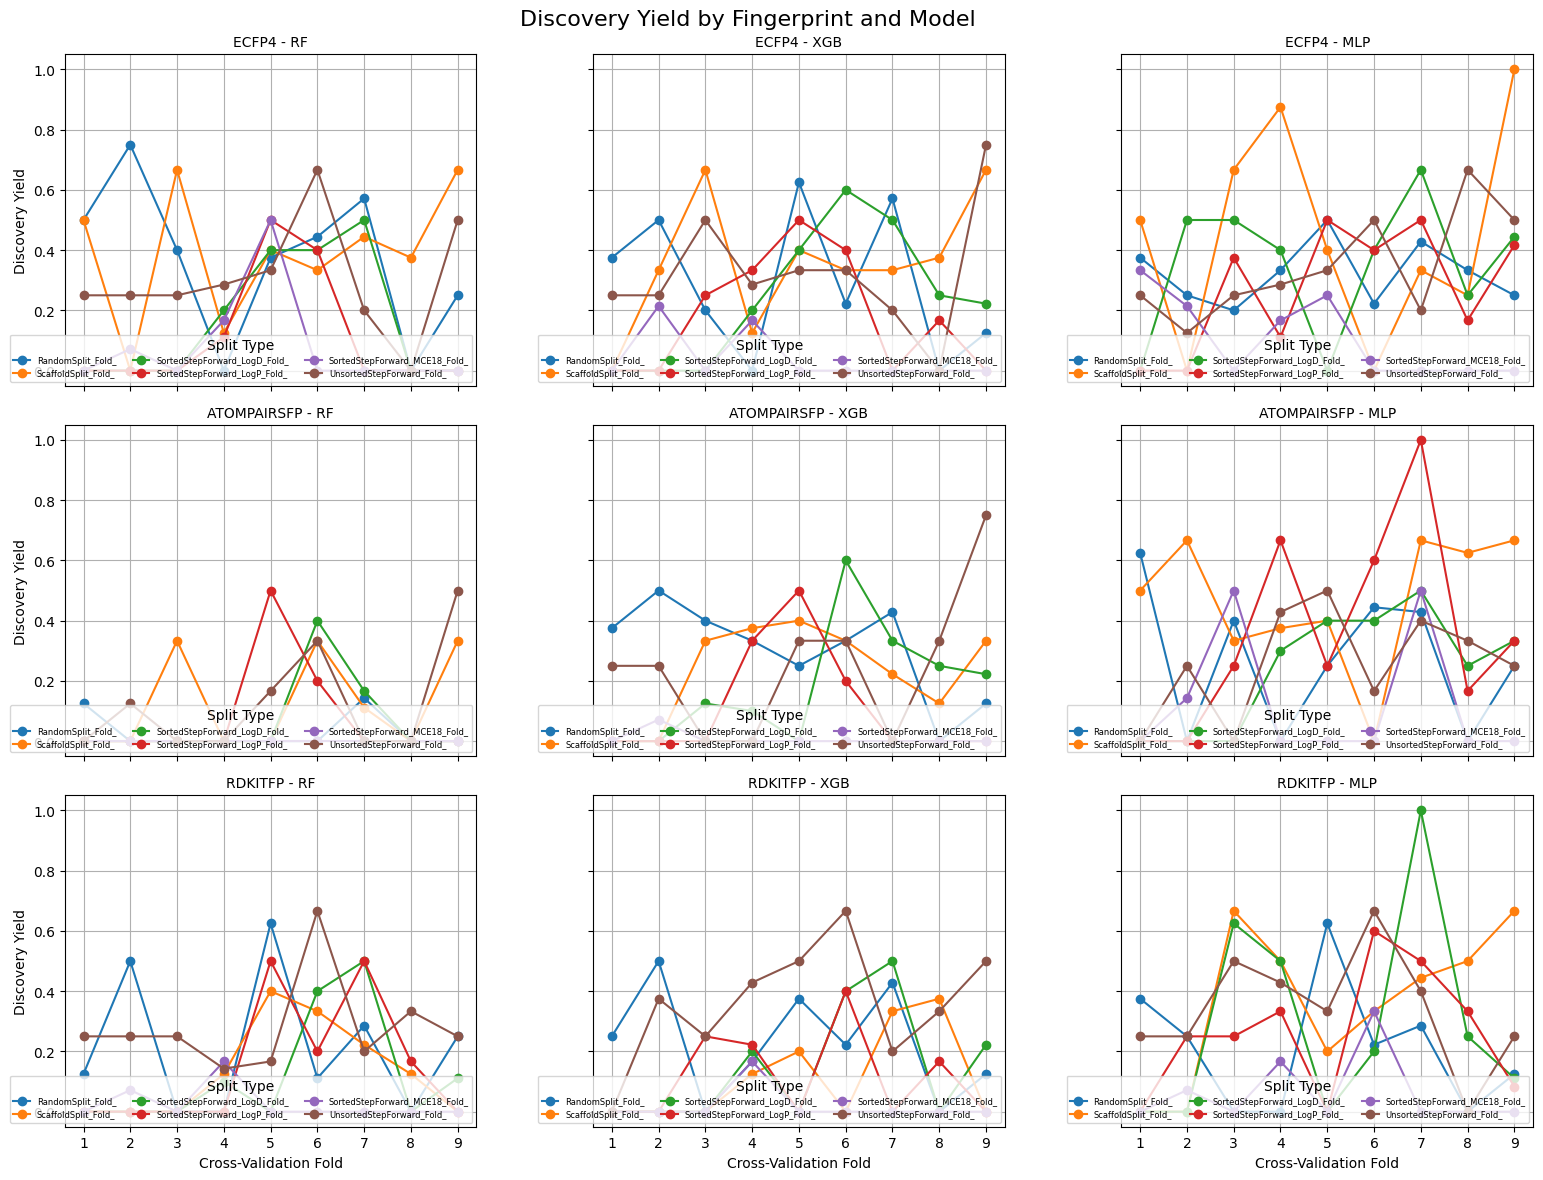

In [10]:
def plot_discovery_yield_grid(
        df,
        error_range=0.5,
        condition="pchembl_value < 5.2",
        split_types=split_types,
        fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"],
        models=["rf", "xgb", "mlp"]
):
    fig, axes = plt.subplots(len(fp_cols), len(models), figsize=(16, 12), sharex=True, sharey=True)

    for i, fp_col in enumerate(fp_cols):
        for j, model in enumerate(models):
            ax = axes[i, j] if len(fp_cols) > 1 else axes[j]  # Handle axes for a single row
            for split_prefix in split_types:
                # Identify prediction columns for the split, fingerprint, and model
                pred_cols = [col for col in df.columns if col.startswith(f"{split_prefix}") and col.endswith(
                    f"_{fp_col}_{model}_regressor_factory")]
                discovery_yields = []

                for pred_col in pred_cols:
                    # Filter test set compounds
                    split_col = pred_col.replace(f"_{fp_col}_{model}_regressor_factory", "")
                    test_indices = df.index[df[split_col] == "Test"]

                    # Extract true and predicted values
                    true_values = df.loc[test_indices, "pchembl_value"]
                    predicted_values = df.loc[test_indices, pred_col]

                    # Evaluate the discovery condition
                    discovery_condition = df.loc[test_indices].eval(condition)

                    # Check predictions within the error range
                    within_error_condition = abs(true_values - predicted_values) <= error_range
                    correctly_predicted = discovery_condition & within_error_condition

                    # Calculate Discovery Yield (fraction)
                    total_discovery = discovery_condition.sum()
                    yield_fraction = correctly_predicted.sum() / total_discovery if total_discovery > 0 else 0
                    discovery_yields.append(yield_fraction)

                # Add the results for this split type to the subplot
                ax.plot(
                    range(1, len(discovery_yields) + 1),
                    discovery_yields,
                    marker='o',
                    label=f"{split_prefix}"
                )

            # Customize each subplot
            ax.set_title(f"{fp_col.upper()} - {model.upper()}", fontsize=10)
            if j == 0:
                ax.set_ylabel("Discovery Yield", fontsize=10)
            if i == len(fp_cols) - 1:
                ax.set_xlabel("Cross-Validation Fold", fontsize=10)
            ax.legend(title="Split Type", fontsize=6, ncols=3, loc="lower right")
            ax.grid(True)

    fig.suptitle("Discovery Yield by Fingerprint and Model", fontsize=16)
    plt.tight_layout()
    plt.show()


# Example usage
plot_discovery_yield_grid(df, error_range=0.5, condition="pchembl_value < 5.2")

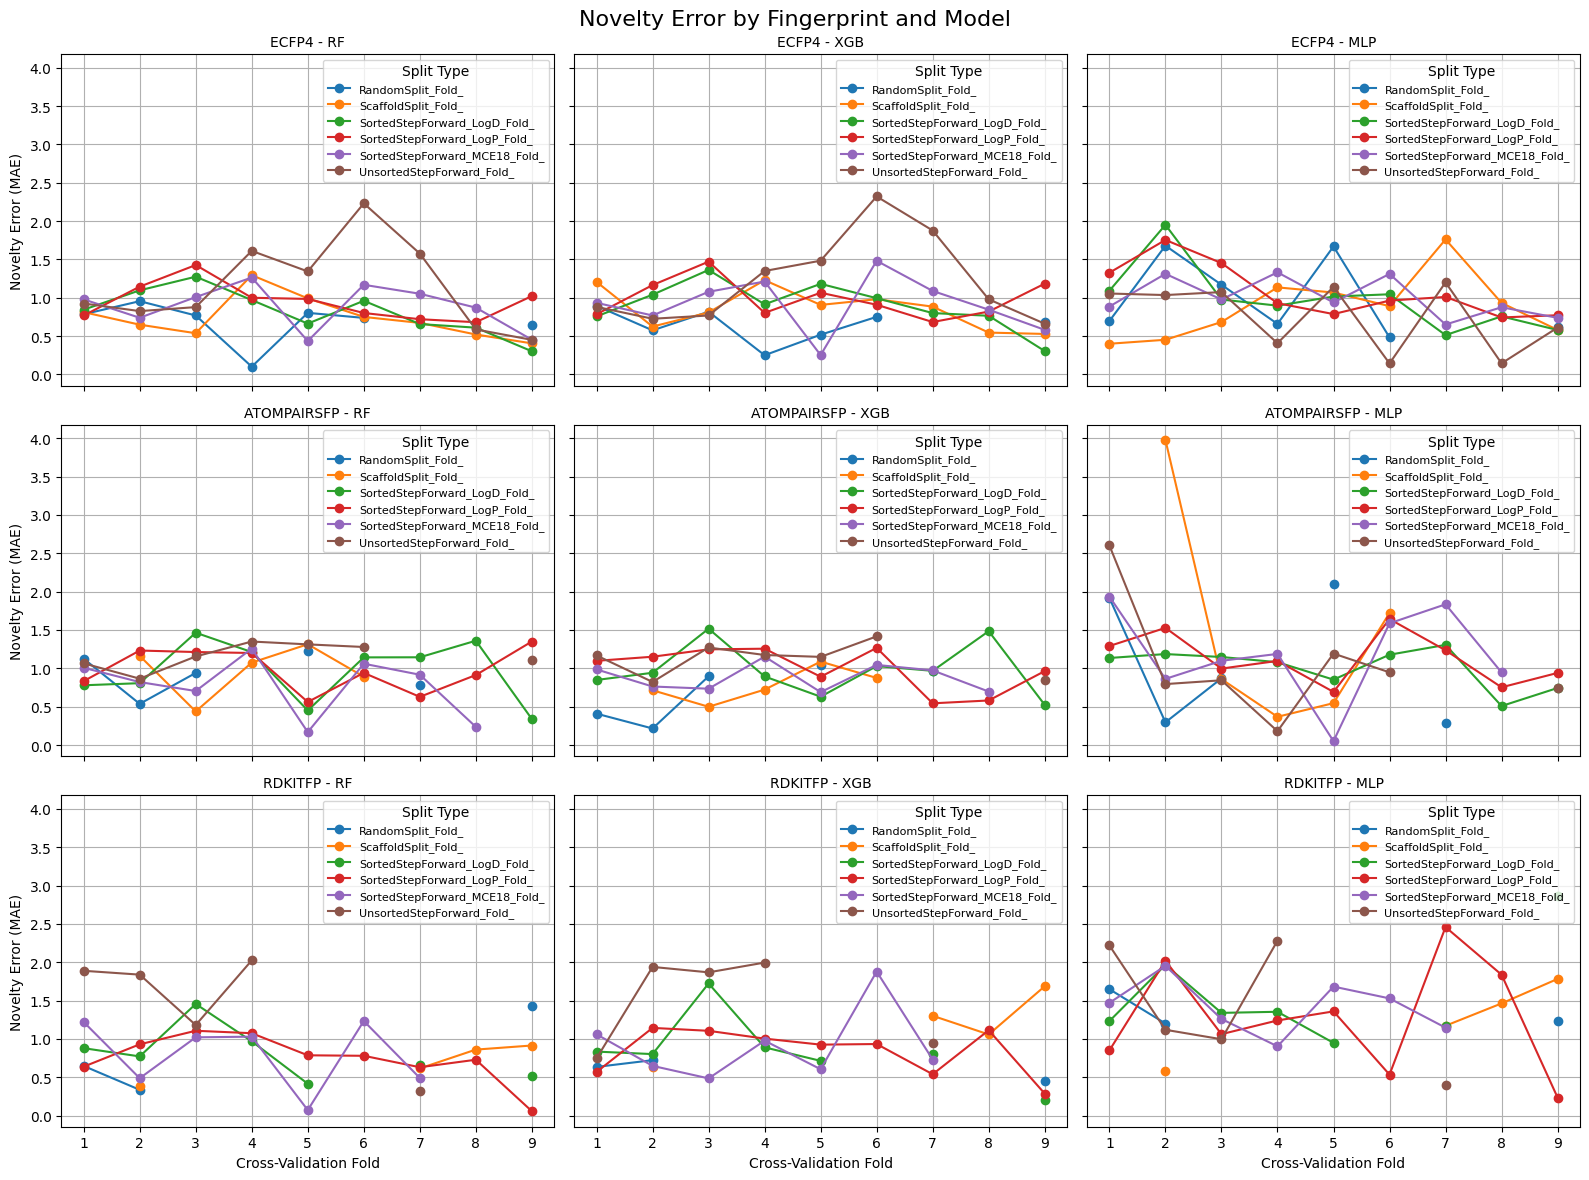

In [11]:
def plot_novelty_error_grid(
        df,
        similarity_threshold=0.55,
        split_types=split_types,
        fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"],
        models=["rf", "xgb", "mlp"]
):
    fig, axes = plt.subplots(len(fp_cols), len(models), figsize=(16, 12), sharex=True, sharey=True)

    for i, fp_col in enumerate(fp_cols):
        for j, model in enumerate(models):
            ax = axes[i, j] if len(fp_cols) > 1 else axes[j]  # Handle axes for a single row
            for split_prefix in split_types:
                # Identify prediction columns for the split, fingerprint, and model
                pred_cols = [col for col in df.columns if col.startswith(f"{split_prefix}") and col.endswith(
                    f"_{fp_col}_{model}_regressor_factory")]
                novelty_errors = []

                for pred_col in pred_cols:
                    # Extract fold number dynamically
                    match = re.search(rf"Fold_(\d+)", pred_col)
                    if not match:
                        "WTF"
                        continue
                    fold_number = match.group(1)

                    # Construct the corresponding similarity column name
                    similarity_col = f"{split_prefix}{fold_number}_{fp_col}_Tc"

                    if similarity_col not in df.columns:
                        print(similarity_col)
                        continue  # Skip if the similarity column doesn't exist

                    # Filter test set compounds
                    split_col = pred_col.replace(f"_{fp_col}_{model}_regressor_factory", "")
                    test_indices = df.index[df[split_col] == "Test"]

                    # Extract true and predicted values
                    true_values = df.loc[test_indices, "pchembl_value"]
                    predicted_values = df.loc[test_indices, pred_col]

                    # Filter dissimilar compounds (Tc < similarity_threshold)
                    dissimilar_condition = df.loc[test_indices, similarity_col] < similarity_threshold
                    dissimilar_indices = df.loc[test_indices][dissimilar_condition].index

                    # Calculate Mean Absolute Error (MAE) for dissimilar compounds
                    if len(dissimilar_indices) > 0:
                        mae = abs(true_values.loc[dissimilar_indices] - predicted_values.loc[dissimilar_indices]).mean()
                    else:
                        mae = None  # No dissimilar compounds for this fold

                    novelty_errors.append(mae)

                # Add the results for this split type to the subplot
                ax.plot(
                    range(1, len(novelty_errors) + 1),
                    novelty_errors,
                    marker='o',
                    label=f"{split_prefix}"
                )

            # Customize each subplot
            ax.set_title(f"{fp_col.upper()} - {model.upper()}", fontsize=10)
            if j == 0:
                ax.set_ylabel("Novelty Error (MAE)", fontsize=10)
            if i == len(fp_cols) - 1:
                ax.set_xlabel("Cross-Validation Fold", fontsize=10)
            ax.legend(title="Split Type", fontsize=8, loc="upper right")
            ax.grid(True)

    fig.suptitle("Novelty Error by Fingerprint and Model", fontsize=16)
    plt.tight_layout()
    plt.show()


plot_novelty_error_grid(df, similarity_threshold=0.55)

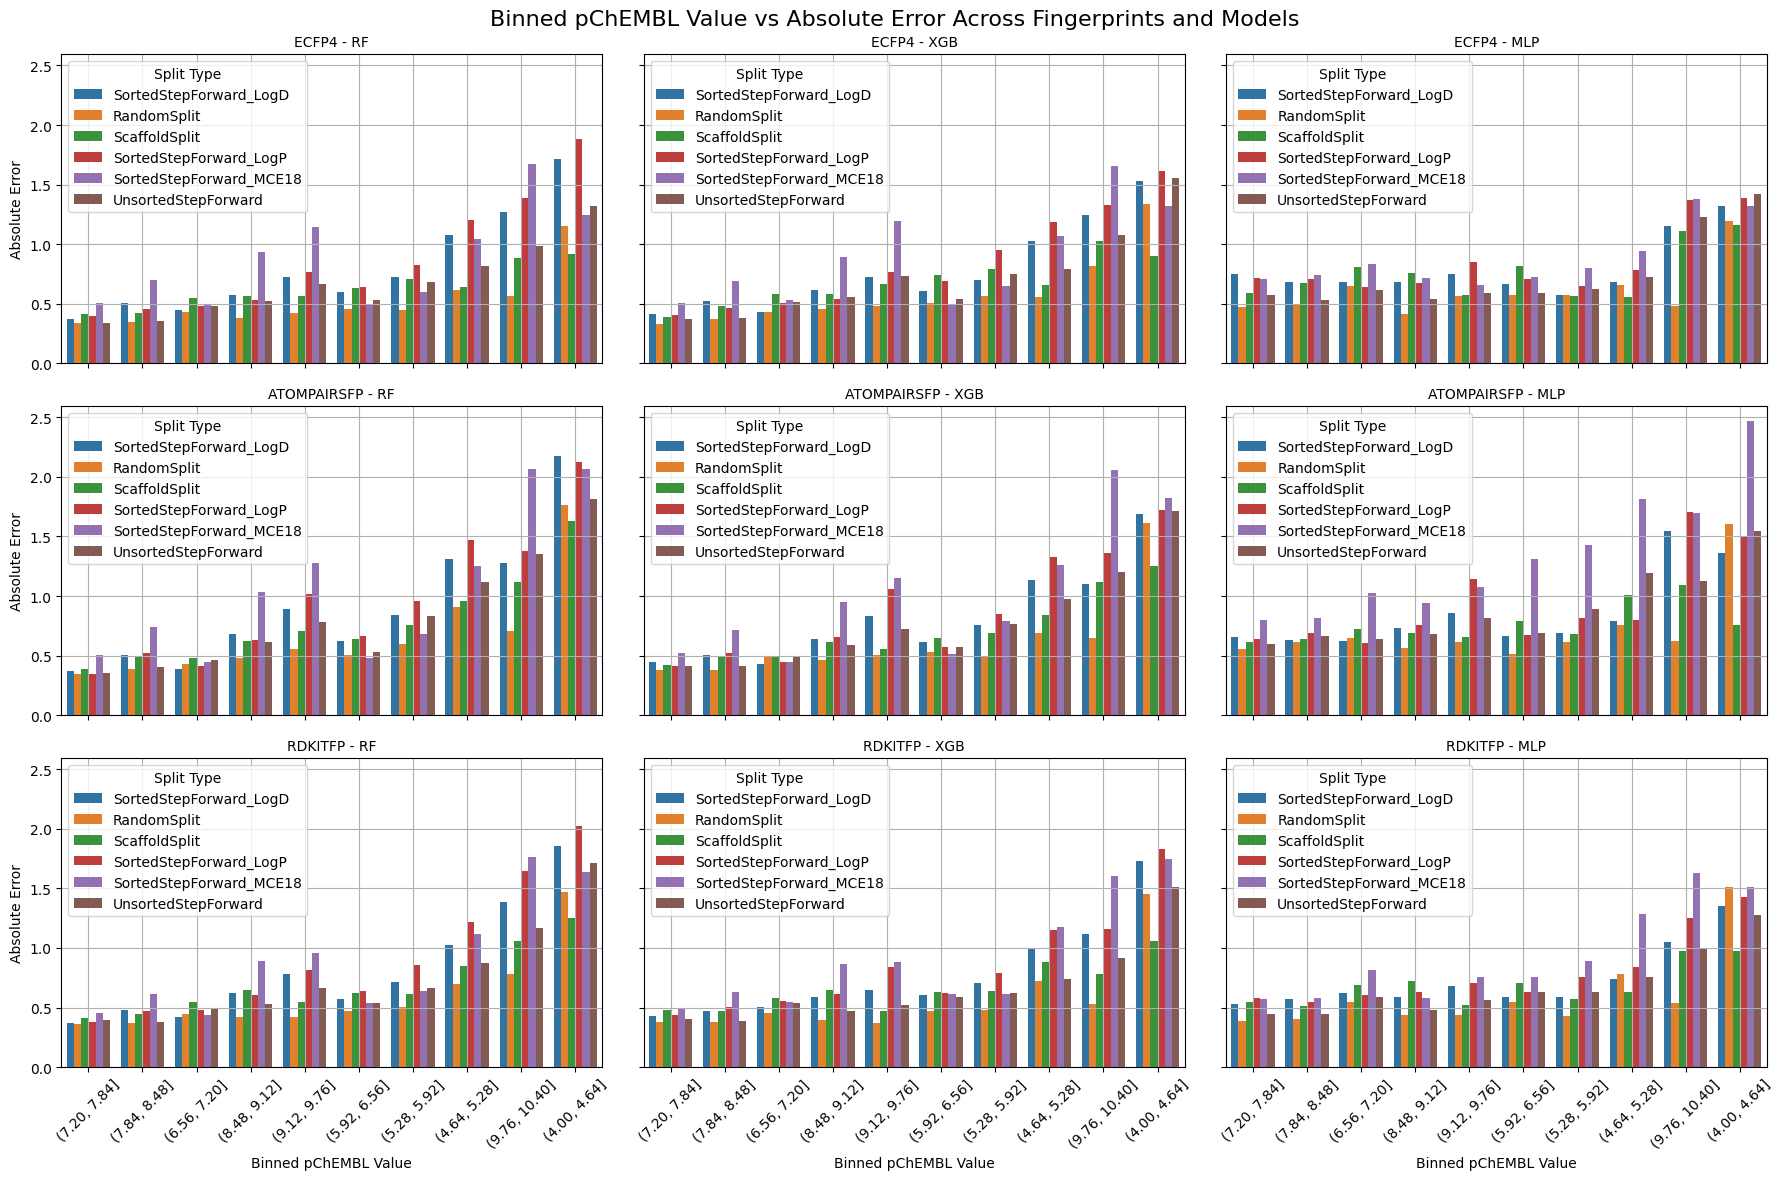

In [12]:
split_types = ['SortedStepForward_LogD', 'RandomSplit', 'ScaffoldSplit', 'SortedStepForward_LogP', 'SortedStepForward_MCE18', 'UnsortedStepForward']

def plot_binned_pchembl_barplot_grid(
        df,
        split_types,
        fp_cols=["ECFP4", "AtomPairsFP", "RDKitFP"],
        models=["rf", "xgb", "mlp"],
        bins=10
):
    num_rows = len(fp_cols)
    num_cols = len(models)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12), sharex=True, sharey=True)
    axes = np.array(axes).reshape(num_rows, num_cols)
    
    bin_edges = np.linspace(df["pchembl_value"].min(), df["pchembl_value"].max(), bins + 1)
    bin_labels = [f"({bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]" for i in range(len(bin_edges) - 1)]

    for i, fp_col in enumerate(fp_cols):
        for j, model in enumerate(models):
            ax = axes[i, j]
            
            binned_data = []
            
            for split_prefix in split_types:
                abs_errors_collected = []
                pchembl_values_collected = []
                
                for fold_no in range(1, 10):
                    pred_col = f"{split_prefix}_Fold_{fold_no}_{fp_col}_{model}_regressor_factory"
                    split_col = f"{split_prefix}_Fold_{fold_no}"
                    
                    if pred_col in df.columns and split_col in df.columns:
                        test_indices = df.index[df[split_col] == "Test"]
                        true_values = df.loc[test_indices, "pchembl_value"]
                        predicted_values = df.loc[test_indices, pred_col]
                        abs_errors = abs(true_values - predicted_values)
                        
                        abs_errors_collected.extend(abs_errors)
                        pchembl_values_collected.extend(true_values)
                
                bin_indices = np.digitize(pchembl_values_collected, bin_edges) - 1
                bin_indices = np.clip(bin_indices, 0, bins - 1)
                
                avg_errors_per_bin = {}
                for k, bin_idx in enumerate(bin_indices):
                    bin_label = bin_labels[bin_idx]
                    if bin_label not in avg_errors_per_bin:
                        avg_errors_per_bin[bin_label] = []
                    avg_errors_per_bin[bin_label].append(abs_errors_collected[k])
                
                for bin_label, errors in avg_errors_per_bin.items():
                    binned_data.append({
                        "Absolute Error": np.mean(errors),
                        "Bin": bin_label,
                        "Split Type": split_prefix
                    })
            
            plot_df = pd.DataFrame(binned_data)
            
            sns.barplot(
                x="Bin",
                y="Absolute Error",
                hue="Split Type",
                data=plot_df,
                ax=ax
            )
            
            ax.set_title(f"{fp_col.upper()} - {model.upper()}", fontsize=10)
            if j == 0:
                ax.set_ylabel("Absolute Error", fontsize=10)
            if i == len(fp_cols) - 1:
                ax.set_xlabel("Binned pChEMBL Value", fontsize=10)
            ax.tick_params(axis="x", rotation=45)
            ax.legend(title="Split Type")
            ax.grid(True)

    fig.suptitle("Binned pChEMBL Value vs Absolute Error Across Fingerprints and Models", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function
plot_binned_pchembl_barplot_grid(df, split_types)